In [1]:
# Imports..
from __future__ import division, unicode_literals, print_function

import pims
from pims import pipeline
import trackpy as tp
import os.path
from pandas import HDFStore

# Parameters..
inFileName     = '../../Dropbox (ASU)/TandemRuns/data/videos/TR-T1-002.mp4'
outDir         = '../../Dropbox (ASU)/TandemRuns/data/betrack/' 
cropRegion     = [1360, 2800, 400, 1300]

# Locate features parameters..
fDiameter      = 11
fMinMass       = 300
fMaxSize       = 3
fThreshold     = 10
fEngine        = 'numba'

# Linking parameters..
lSearchRange   = 50
lMemory        = 30
lPercThreshold = 0.1

In [2]:
# Convert to grayscale using lazy evaluation
# see: http://scikit-image.org/docs/dev/user_guide/data_types.html
@pipeline
def as_gray(frame, invert=True):

    if (invert):
        red   = 255 - frame[:, :, 0]
        blue  = 255 - frame[:, :, 1]
        green = 255 - frame[:, :, 2]
    else:
        red   = frame[:, :, 0]
        blue  = frame[:, :, 1]
        green = frame[:, :, 2]
        
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

In [3]:
# Crop frame to region of interest
@pipeline
def crop(frame, region):
    return frame[region[2]:region[3], region[0]:region[1]]

In [4]:
# Read the video, crop it and convert it to grayscale..
frames   = pims.Video(inFileName)
cframes  = crop(frames, cropRegion)
gsframes = as_gray(cframes, invert=True)

In [17]:
h5StorageFile = outDir + 'dataStorage.h5'

# Remove storage file if it already exists..
if os.path.isfile(h5StorageFile):
    print('Deleting h5 storage file:', h5StorageFile)
    os.remove(h5StorageFile)

# Locate features in all frames..
with tp.PandasHDFStoreBig(h5StorageFile) as sf:
    tp.batch(gsframes, diameter=fDiameter, minmass=fMinMass, invert=False,
             maxsize=fMaxSize, threshold=fThreshold, engine=fEngine, 
             output=sf)

Frame 3805: 14 features


In [18]:
# Link trajectories in all frames..
with tp.PandasHDFStoreBig(h5StorageFile) as sf:
    for linked in tp.link_df_iter(sf, search_range=lSearchRange, memory=lMemory):
        sf.put(linked)  

Frame 3805: 14 trajectories present.


In [19]:
# Convert trajectories to the size of the original video..
dfLink    = tp.PandasHDFStoreBig(h5StorageFile).dump()
dfLink.y += cropRegion[2]
dfLink.x += cropRegion[0]

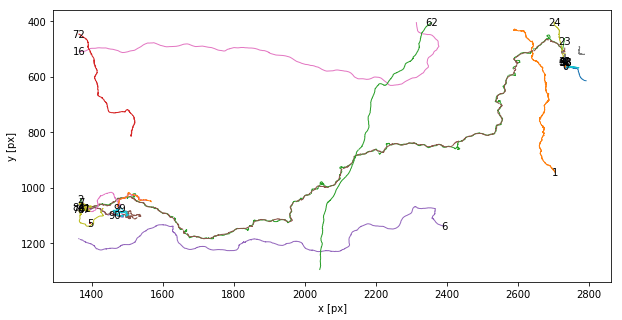

In [21]:
# Plot the trajectories..
import matplotlib as mpl
import matplotlib.pyplot as plt

# %matplotlib notebook for interactive plot
%matplotlib inline

# Tweak styles..
mpl.rc('figure', figsize=(10,5))
mpl.rc('image', cmap='gray')

plt.figure()
tp.plot_traj(dfLink, label=True)

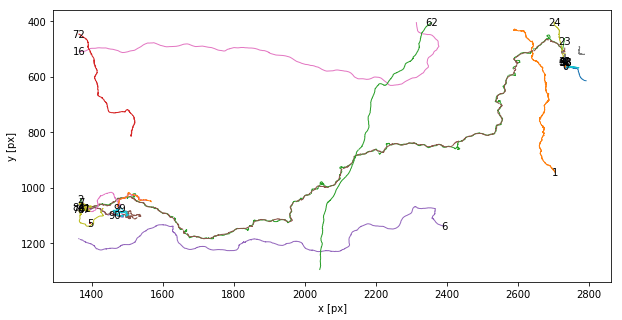

In [22]:
# Filter trajectories by min number of frames..
dfLink = tp.filter_stubs(dfLink, threshold=round(len(frames) * lPercThreshold))

plt.figure()
tp.plot_traj(dfLink, label=True)

In [23]:
# Save trajectories..
h5TracksFile = outDir + 'tracks.h5'

# Remove file if it already exists..
if os.path.isfile(h5TracksFile):
    print('Deleting h5 track file:', h5TracksFile)
    os.remove(h5TracksFile)

# Save file..
print('Saving new h5 track file:', h5TracksFile)
hdf = HDFStore(h5TracksFile)
hdf.put('dfLink', dfLink, format='table', data_columns=True)
hdf.close()

# Remove storage file if it exists..
if os.path.isfile(h5StorageFile):
    print('Deleting h5 storage file:', h5StorageFile)
    os.remove(h5StorageFile)

Deleting h5 track file: ../../Dropbox (ASU)/TandemRuns/data/betrack/tracks.h5
Saving new h5 track file: ../../Dropbox (ASU)/TandemRuns/data/betrack/tracks.h5
Deleting h5 storage file: ../../Dropbox (ASU)/TandemRuns/data/betrack/dataStorage.h5


In [24]:
# Reverse the order of the colors in a frame. Can be used to
# convert RGB frames (trackpy) to BGR frames (opencv) and back.
@pipeline
def reverse_colors(frame):
    return frame[:, :, ::-1]

In [123]:
# Create and save tracked video..
import numpy as np
import cv2 as cv

vFrameStep = 1
vFileName  = outDir + 'output.avi'
vCropVideo = True

cvframes   = reverse_colors(frames)
framerange = np.arange(0, len(frames), vFrameStep)
codec      = cv.VideoWriter_fourcc(b'M', b'J', b'P', b'G')
fps        = 29

if vCropVideo:
    outShape = crop(frames[0], extCropRegion).shape[0:2][::-1]
else:
    outShape = frames.frame_shape[0:2][::-1]
outWriter  = cv.VideoWriter(vFileName, codec, fps, outShape)
font       = cv.FONT_HERSHEY_SIMPLEX
fontScale  = 0.75
pRadius    = 3
pColor     = (25, 100, 255)
rColor     = (0, 255, 0)
thickness  = 2
newRegion  = [a - b for a, b in zip(cropRegion, [50, -50, 50, -50])]


for frame, i in zip(framerange, range(len(framerange))):
    print("Working on frame:", i + 1, "of", len(framerange), "\r", end='')
    
    # Get frame and subset tracks..
    f   = np.array(cvframes[frame])
    dfl = dfLink[dfLink['frame'] == frame]
    
    # Annotate particles..
    for p in dfl['particle']:
        # Get particle position..
        pPos = tuple(dfl[dfl['particle'] == p][['x','y']].astype(int).values[0])
        
        # Add particle id..
        cv.putText(f, str(p), pPos, font, fontScale, pColor, thickness, 
                   lineType=cv.LINE_AA, bottomLeftOrigin=True)
        
        # Add particle position..
        cv.circle(f, pPos, pRadius, pColor, thickness=-1, lineType=cv.LINE_AA)
    
    # Draw tracked region..    
    tlPos = (cropRegion[0], cropRegion[2])
    brPos = (cropRegion[1], cropRegion[3])    
    cv.rectangle(f, tlPos, brPos, rColor, thickness, lineType=cv.LINE_AA)
     
    # Add frame number..
    fPos = (cropRegion[0], cropRegion[3] + 5)
    cv.putText(f, 'Frame: ' + str(frame), fPos, font, fontScale, rColor, thickness,
                   lineType=cv.LINE_AA, bottomLeftOrigin=True)
    
    # Crop video..
    if vCropVideo:
        f = crop(f, newRegion)

    # Flip frame vertically..
    cv.flip(f, flipCode=0, dst=f)
        
    # Write frame to output file..
    outWriter.write(f)

# Release video writer
outWriter.release()

In [54]:
v = frames[0]
frames.pixel_type == 'uint8'
period = [0, 4]
len(frames[range(period[0], period[1])])

4